# Potential Talents - An Apziva Project (#3)

# EDA

By Samuel Alter

Apziva: 6bImatZVlK6DnbEo

## Project Overview

We are working with a talent sourcing and management company to help them surface candidates that are a best fit for their human resources job post. We are using a dataset of job candidates' job titles, their location, and their number of LinkedIn connections.

### Goals

Produce a probability, between 0 and 1, of how closely the candidate fits the job description of **"Aspiring human resources"** or **"Seeking human resources."** After an initial recommendation pulls out a candidate(s) to be starred for future consideration, the recommendation will be re-run and new "stars" will be awarded.

To help predict how the candidates fit, we are tracking the performance of two success metrics:
* Rank candidates based on a fitness score
* Re-rank candidates when a candidate is starred

We also need to do the following:
* Explain how the algorithm works and how the ranking improves after each starring iteration
* How to filter out candidates which should not be considered at all
* Determine a cut-off point (if possible) that would work for other roles without losing high-potential candidates
* Ideas to explore on automating this procedure to reduce or eliminate human bias

### The Dataset

| Column | Data Type | Comments |
|---|---|---|
| `id` | Numeric | Unique identifier for the candidate |
| `job_title` | Text | Job title for the candidate |
| `location` | Text | Geographic location of the candidate |
| `connections` | Text | Number of LinkedIn connections for the candidate |

Connections over 500 are encoded as "500+". Some do not have specific locations listed and just had their country, so I substituted capitol cities or geographic centers to represent those countries.

## Imports and Helper Functions

In [705]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import joblib
import time
from datetime import datetime
import json
from pathlib import Path
import inspect
import re
import string
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import geopandas as gpd
import duckdb
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import FancyArrow
import io

In [585]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
from nltk.corpus import stopwords # lists of stopwords
from nltk.tokenize import word_tokenize # tool for splitting documents into tokens
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer # basic stemmer
from nltk.stem import WordNetLemmatizer # more sophisticated word->lemma
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /Users/sra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/sra/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/sra/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/sra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [586]:
def nltk_updater():
    import nltk
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('averaged_perceptron_tagger_eng')
    nltk.download('stopwords')
    from nltk.corpus import stopwords # lists of stopwords
    from nltk.tokenize import word_tokenize # tool for splitting documents into tokens
    from nltk.tokenize import sent_tokenize
    from nltk.stem import PorterStemmer # basic stemmer
    from nltk.stem import WordNetLemmatizer # more sophisticated word->lemma
    from nltk.corpus import wordnet
    from sklearn.feature_extraction.text import TfidfVectorizer

In [587]:
from gensim.models import Word2Vec, KeyedVectors

In [588]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [589]:
seed=rand_gen()
seed

2395

In [590]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x339903820

In [591]:
def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [name for name, val in callers_local_vars if val is var]

def fileDaterSaver(location: str,
                   filetype: str,
                   object_,
                   extra: str = '',
                   verbose: bool = True):

    '''
    Function that gets a timestamped filename and saves it
    to a user-specified location.

    Parameters:
    -----------
    location: str - The location where the file will be saved.
    filetype: str - The type of the file to save ('csv' or 'json').
    object_: The object to be saved. Should be a pandas DataFrame
        for 'csv' or serializable for 'json'.
    extra: str - Additional string to include in the filename.
    verbose: bool - Whether to print verbose messages.
    '''

    # get current date and time
    current_datetime = datetime.now()

    # print current date and time to check
    if verbose:
        print('current_datetime:', current_datetime)

    # format the datetime for a filename
    datetime_suffix = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # create filename with the datetime suffix
    if extra != '':
        file_name = f'{location}{extra}_{datetime_suffix}.{filetype}'
    else:
        file_name = f'{location}{datetime_suffix}.{filetype}'

    # print file name
    if verbose:
        print(file_name)

    # save object
    if filetype == 'csv':
        object_.to_csv(file_name, index=True)
    elif filetype == 'json':
        with open(file_name, 'w') as file:
            file.write(json.dumps(object_, default=str))
    else:
        raise ValueError("Unsupported file type. Use 'csv' or 'json'.")

    # confirm save
    file_path = Path(file_name)
    if file_path.exists():
        variable_name = get_variable_name(object_)
        if variable_name:
            print(f'Successfully saved {variable_name[0]} to {file_path}')
        else:
            print(f'Successfully saved object to {file_path}')
    else:
        print("File save error.")

Read in the datset:

In [592]:
df=pd.read_csv('../data/3_data.csv')
df.head(3)

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN


## Analysis

In [593]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


No nulls in the dataset. That is nice for us! There are 104 total observations.

In [594]:
df['fit'].value_counts()

Series([], Name: count, dtype: int64)

We'll remove `fit` as it is a column with no data.

In [595]:
if 'fit' in df.columns: # flow control for repeat code executions
    df.drop('fit',axis=1,inplace=True)

df.head()

,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+


Inspect the connections column:

In [596]:
connections=df['connection'].value_counts()

connections

connection
500+     44
85        7
61        7
44        6
1         5
2         4
4         2
7         2
57        2
390       2
103       1
48        1
18        1
71        1
19        1
415       1
9         1
64        1
39        1
155       1
349       1
174       1
40        1
50        1
268       1
455       1
52        1
409       1
212       1
16        1
5         1
82        1
49        1
Name: count, dtype: int64

I will change the "500+" into 500 so that it can remain a numeric value.

In [597]:
# remove all non-numeric characters from the column
column='connection'
if not pd.api.types.is_numeric_dtype(df[column]):
    df[column]=df[column].str.replace(r'\D','',regex=True)

    # check if any '+' characters are still present
    print("Amount of '+' in column:",df[column].str.contains(r'\+').sum())

    # convert to integer
    df[column]=pd.to_numeric(df[column],errors='coerce')
    print(df.dtypes)

    # check if conversion was successful
    print('\nWas conversion successful?')
    if pd.api.types.is_numeric_dtype(df[column]):
        print('Yes.')
    else:
        print('No.')
else:
    print(f'There are no non-numeric characters in the column: {column}')

Amount of '+' in column: 0
id             int64
job_title     object
location      object
connection     int64
dtype: object

Was conversion successful?
Yes.


### Histogram of Connections

In [598]:
# remove the >500 connection observations
df_no500 = df[df['connection']<500]

# check
df_no500['connection'].value_counts().head(3)

connection
85    7
61    7
44    6
Name: count, dtype: int64

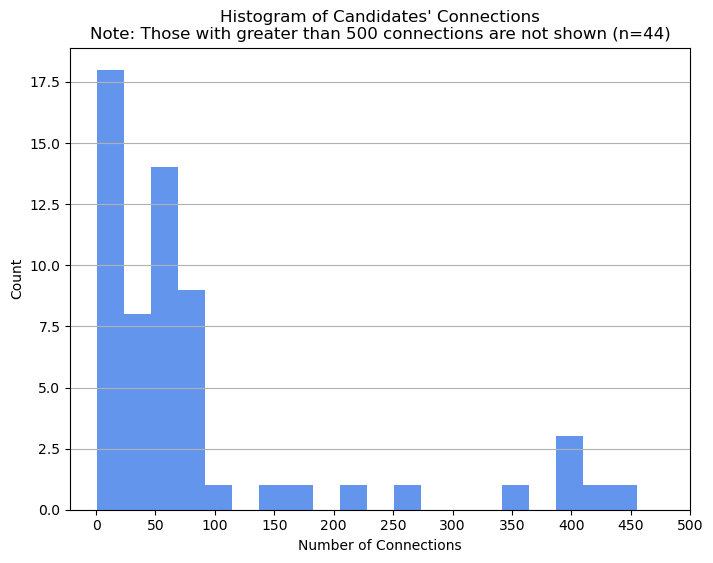

In [599]:
plt.figure(figsize=(8,6))
plt.hist(x=df_no500['connection'],
         color='cornflowerblue',
         bins=20)
plt.title("Histogram of Candidates' Connections\nNote: Those with greater than 500 connections are not shown (n=44)")
plt.xlabel('Number of Connections')
plt.ylabel('Count')
plt.grid(which='both',axis='y')
plt.xticks(range(0,501,50)) # get xticks to appear every 50 connections

plt.savefig('figures/3_histogram_connections.pdf',bbox_inches='tight')
plt.savefig('figures/3_histogram_connections.jpg',bbox_inches='tight')
plt.savefig('figures/3_histogram_connections.png',bbox_inches='tight')

plt.show()

### Boxplot of Connections

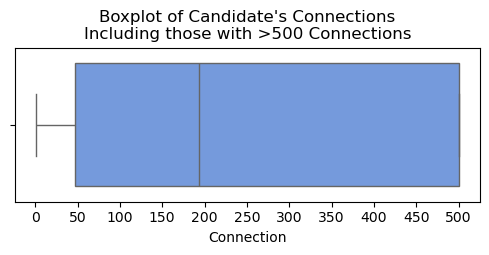

In [600]:
plt.figure(figsize=(6,2))
sns.boxplot(x=df['connection'],color='cornflowerblue')
plt.title("Boxplot of Candidate's Connections\nIncluding those with >500 Connections")
plt.xlabel('Connection')
plt.xticks(range(0,501,50))

plt.savefig('figures/3_boxplot_connections.pdf',bbox_inches='tight')
plt.savefig('figures/3_boxplot_connections.jpg',bbox_inches='tight')
plt.savefig('figures/3_boxplot_connections.png',bbox_inches='tight')

plt.show()

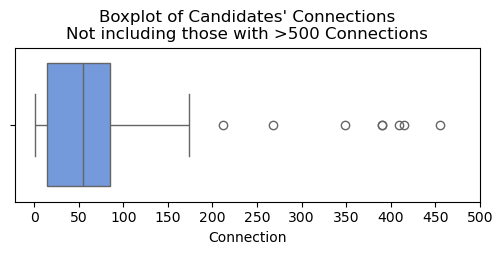

In [601]:
plt.figure(figsize=(6,2))
plt.tight_layout()
sns.boxplot(x=df_no500['connection'],color='cornflowerblue')
plt.title("Boxplot of Candidates' Connections\nNot including those with >500 Connections")
plt.xlabel('Connection')
plt.xticks(range(0,501,50))

plt.savefig('figures/3_boxplot_no500.pdf',bbox_inches='tight')
plt.savefig('figures/3_boxplot_no500.jpg',bbox_inches='tight')
plt.savefig('figures/3_boxplot_no500.png',bbox_inches='tight')

plt.show()

### Map of Observations

In [602]:
df['location'].value_counts()

location
Kanada                                 12
Raleigh-Durham, North Carolina Area     8
Houston, Texas Area                     8
Greater New York City Area              7
Houston, Texas                          7
Denton, Texas                           6
San Francisco Bay Area                  5
Greater Philadelphia Area               5
İzmir, Türkiye                          4
Lake Forest, California                 4
Atlanta, Georgia                        4
Chicago, Illinois                       2
Austin, Texas Area                      2
Greater Atlanta Area                    2
Amerika Birleşik Devletleri             2
Long Beach, California                  1
Milpitas, California                    1
Greater Chicago Area                    1
Torrance, California                    1
Greater Los Angeles Area                1
Bridgewater, Massachusetts              1
Lafayette, Indiana                      1
Kokomo, Indiana Area                    1
Las Vegas, Nevada Area   

In [603]:
# number of unique locations in dataset
df['location'].nunique()

41

This is not terrible. I'd like to get the location for each municipality to create a chloropleth map of the locations.

First step is to clean this column to make it easier to get the locations. We won't go fully intense with the geospatial information, so if the city says "Greater CITY Area," I'll just make that "CITY" to simplify things.

In [604]:
# data from here:
# https://github.com/kelvins/US-Cities-Database
cities=pd.read_csv('../data/us_cities.csv')
cities.head(3)

,ID,STATE_CODE,STATE_NAME,CITY,COUNTY,LATITUDE,LONGITUDE
0,1,AK,Alaska,Adak,Aleutians West,55.999722,-161.207778
1,2,AK,Alaska,Akiachak,Bethel,60.891854,-161.392330
2,3,AK,Alaska,Akiak,Bethel,60.890632,-161.199325


In [605]:
# find cities
_=cities[cities['CITY'].str.contains('Katy')]
_

# I also used Google Earth Pro

,ID,STATE_CODE,STATE_NAME,CITY,COUNTY,LATITUDE,LONGITUDE
25488,25489,TX,Texas,Katy,Fort Bend,29.750893,-95.811675
25489,25490,TX,Texas,Katy,Harris,29.819922,-95.729267


In [606]:
city_loc_map={
    'Kanada':{'lat':45.424721,'lon':-75.695,'name':'Canada'}, # choosing Ottowa
    'Raleigh-Durham, North Carolina Area':{'lat':35.772701,'lon':-78.632439,'name':'Raleigh'},
    'Houston, Texas Area':{'lat':29.765200,'lon':-95.365700,'name':'Houston'},
    'Greater New York City Area':{'lat':40.748380,'lon':-73.996705,'name':'New_York_City'},
    'Houston, Texas':{'lat':29.765200,'lon':-95.365700,'name':'Houston'},
    'Denton, Texas':{'lat':33.22893,'lon':-97.131436,'name':'Denton'},
    'San Francisco Bay Area':{'lat':37.775,'lon':-122.4183,'name':'San_Francisco'},
    'Greater Philadelphia Area':{'lat':39.864998,'lon':-75.275196,'name':'Philadelphia'},
    'İzmir, Türkiye':{'lat':38.4228,'lon':27.1404,'name':'İzmir'},
    'Lake Forest, California':{'lat':33.640015,'lon':-117.68819,'name':'Lake_Forest_CA'},
    'Atlanta, Georgia':{'lat':33.7564,'lon':-84.3918,'name':'Atlanta'},
    'Chicago, Illinois':{'lat':41.885847,'lon':-87.618123,'name':'Chicago'},
    'Austin, Texas Area':{'lat':30.2303,'lon':-97.7144,'name':'Austin'},
    'Greater Atlanta Area':{'lat':33.7564,'lon':-84.3918,'name':'Atlanta'},
    'Amerika Birleşik Devletleri':{'lat':39.833333,'lon':-98.583333,'name':'United_States'},
    'Long Beach, California':{'lat':33.7705,'lon':-118.1885,'name':'Long_Beach'},
    'Milpitas, California':{'lat':37.436491,'lon':-121.892885,'name':'Milpitas'},
    'Greater Chicago Area':{'lat':41.885847,'lon':-87.618123,'name':'Chicago'},
    'Torrance, California':{'lat':33.826817,'lon':-118.31183,'name':'Torrance'},
    'Greater Los Angeles Area':{'lat':33.973093,'lon':-118.247896,'name':'Los_Angeles'},
    'Bridgewater, Massachusetts':{'lat':41.977341,'lon':-70.97234,'name':'Bridgewater_MA'},
    'Lafayette, Indiana':{'lat':40.417743,'lon':-86.888358,'name':'Lafayette_IN'},
    'Kokomo, Indiana Area':{'lat':40.498840,'lon':-86.145273,'name':'Kokomo_IN'},
    'Las Vegas, Nevada Area':{'lat':36.172082,'lon':-115.122366,'name':'Las_Vegas'},
    'Cape Girardeau, Missouri':{'lat':37.31685,'lon':-89.545861,'name':'Cape_Girardeau'},
    'Gaithersburg, Maryland':{'lat':39.14187,'lon':-77.188993,'name':'Gaithersburg'},
    'Baltimore, Maryland':{'lat':39.294630,'lon':-76.625203,'name':'Baltimore_MD'},
    'Dallas/Fort Worth Area':{'lat':32.778,'lon':-96.7968,'name':'Dallas'},
    'Highland, California':{'lat':34.126969,'lon':-117.208717,'name':'Highland_CA'},
    'Los Angeles, California':{'lat':33.973093,'lon':-118.247896,'name':'Los_Angeles'},
    'Chattanooga, Tennessee Area':{'lat':35.045500,'lon':-85.308100,'name':'Chattanooga'},
    'Myrtle Beach, South Carolina Area':{'lat':33.758701,'lon':-78.804448,'name':'Myrtle_Beach'},
    'Baton Rouge, Louisiana Area':{'lat':30.450731,'lon':-91.186954,'name':'Baton_Rouge'},
    'New York, New York':{'lat':40.748380,'lon':-73.996705,'name':'New_York_City'},
    'San Jose, California':{'lat':37.389400,'lon':-121.886800,'name':'San_Jose'},
    'Greater Boston Area':{'lat':42.357603,'lon':-71.068432,'name':'Boston_MA'},
    'Monroe, Louisiana Area':{'lat':32.528551,'lon':-92.106104,'name':'Monroe_LA'},
    'Virginia Beach, Virginia':{'lat':36.8527,'lon':-75.9783,'name':'Virginia_Beach'},
    'Greater Grand Rapids, Michigan Area':{'lat':42.970400,'lon':-85.673800,'name':'Grand_Rapids_MI'},
    'Jackson, Mississippi Area':{'lat':32.293502,'lon':-90.186655,'name':'Jackson_MS'},
    'Katy, Texas':{'lat':29.7828,'lon':-95.8212,'name':'Katy_TX'}
}

city_loc_map = pd.DataFrame(city_loc_map).T.reset_index(names="original_name")
city_loc_map = city_loc_map.drop(columns=['index'], errors='ignore') 

In [607]:
city_loc_map.head()

,original_name,lat,lon,name
0,Kanada,45.424721,-75.695,Canada
1,"Raleigh-Durham, North Carolina Area",35.772701,-78.632439,Raleigh
2,"Houston, Texas Area",29.7652,-95.3657,Houston
3,Greater New York City Area,40.74838,-73.996705,New_York_City
4,"Houston, Texas",29.7652,-95.3657,Houston


In [608]:
# merge dataframes to include new spatial information
if 'lat' not in df.columns:
    print('Merging tables')
    df=df.merge(city_loc_map[['original_name','lat','lon','name']],
               left_on='location',
               right_on='original_name',
               how='left')

    df=df.drop(columns=['original_name'])

print('df has already been merged')
df.head(3)

Merging tables
df has already been merged


,id,job_title,location,connection,lat,lon,name
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,29.7652,-95.3657,Houston
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500,45.424721,-75.695,Canada
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,35.772701,-78.632439,Raleigh


In [609]:
# check if there's an equal number of latitudes for the city names
df['lat'].value_counts().count()==df['name'].value_counts().count()

True

Excellent! We successfully added the city location. Now let's make a chloropleth map (or something similar) showing the geographic distribution of the applicants.

We almost forgot: let's now make a table that shows the sum of applicants at each location.

In [610]:
con=duckdb.connect(database=':memory:')
con.register('df',df)
ct_cities=con.execute('''
select
    count(name) as ct
    ,lat
    ,lon
    ,name
from df
group by name,lat,lon;
''').fetchdf()
con.close()
ct_cities.head()

,ct,lat,lon,name
0,1,32.293502,-90.186655,Jackson_MS
1,1,36.852700,-75.978300,Virginia_Beach
2,2,39.833333,-98.583333,United_States
3,1,37.436491,-121.892885,Milpitas
4,1,29.782800,-95.821200,Katy_TX


In [611]:
# downloaded from something like
# https://github.com/georgique/world-geojson
borders=gpd.read_file('../data/world_borders.geojson')
borders.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


I'll make two maps, one of North America and another of Tükiye.

In [612]:
con=duckdb.connect(database=':memory:')
con.register('ct_cities',ct_cities)
ct_cities_na=con.execute('''
select
    *
from ct_cities
where lon<27;
''').fetchdf()
con.close()
ct_cities_na.head()

,ct,lat,lon,name
0,1,32.293502,-90.186655,Jackson_MS
1,1,36.852700,-75.978300,Virginia_Beach
2,2,39.833333,-98.583333,United_States
3,1,37.436491,-121.892885,Milpitas
4,1,29.782800,-95.821200,Katy_TX


In [613]:
con=duckdb.connect(database=':memory:')
con.register('ct_cities',ct_cities)
ct_cities_tk=con.execute('''
select
    *
from ct_cities
where lon>27;
''').fetchdf()
con.close()
ct_cities_tk.head()

,ct,lat,lon,name
0,4,38.4228,27.1404,İzmir


In [614]:
# us states geojson from here:
# https://github.com/PublicaMundi/\
# MappingAPI/blob/master/data/geojson/us-states.json
states=gpd.read_file('../data/us-states.json')
states.head()

,id,name,density,geometry
0,01,Alabama,94.650,"POLYGON ((-87.35930 35.00118, -85.60667 34.984..."
1,02,Alaska,1.264,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691..."
2,04,Arizona,57.050,"POLYGON ((-109.04250 37.00026, -109.04798 31.3..."
3,05,Arkansas,56.430,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,06,California,241.700,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."


In [615]:
df.shape

(104, 7)

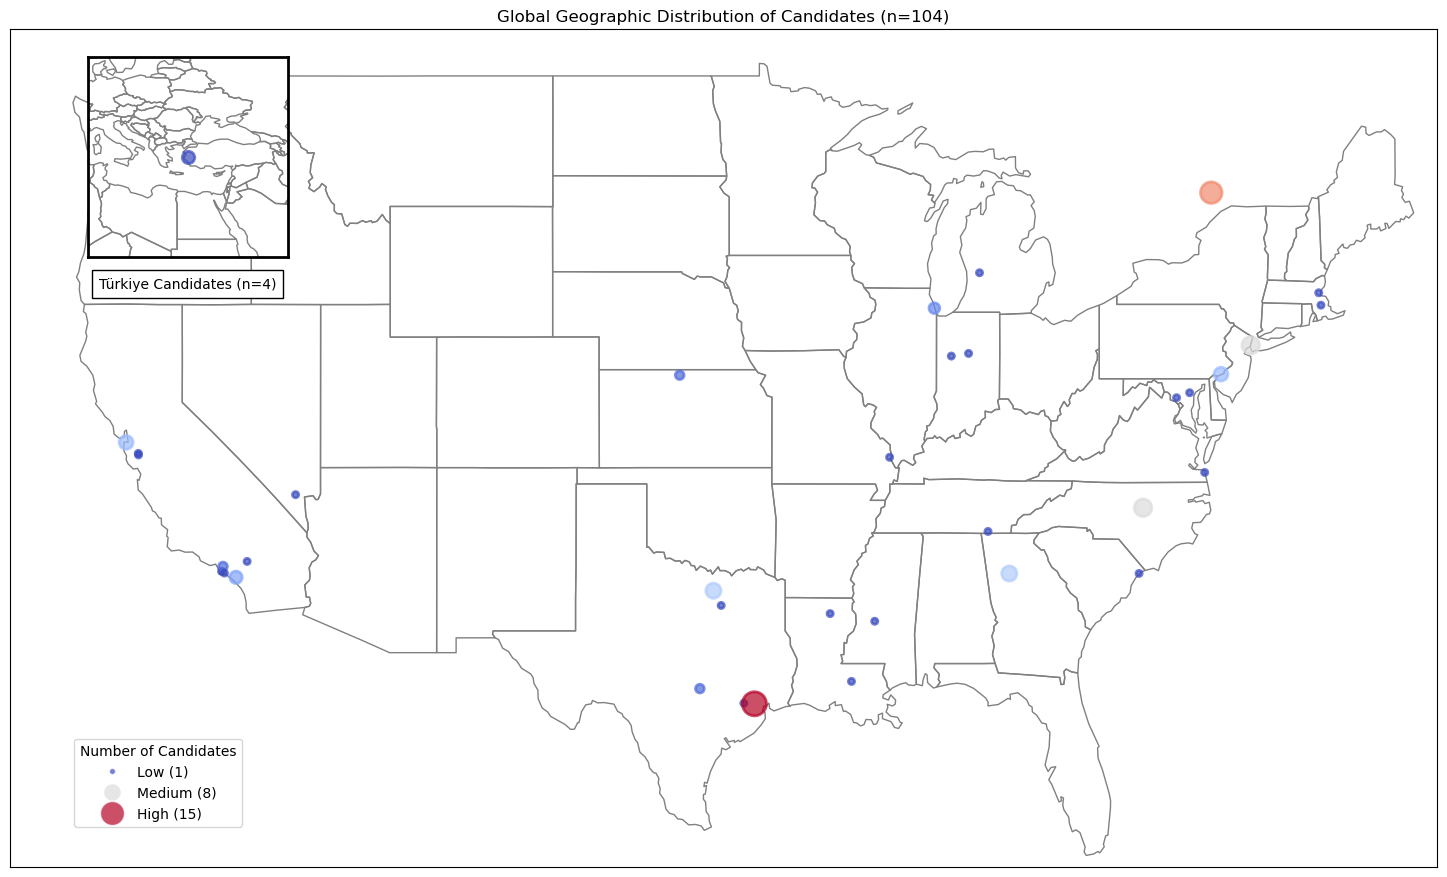

In [616]:
# set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 10))
plt.title(f'Global Geographic Distribution of Candidates (n={df.shape[0]})') 
plt.tight_layout()

# hide x and y axis labels for cleaner map display
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# plot US states
states.plot(ax=ax, edgecolor='grey', facecolor='none')

# plot scatter points for North America data
scale_factor = 20  # to make it more visible
alpha_ = 0.7  # consistent alpha value
cmap='coolwarm'

scatter_na = ax.scatter(
    x=ct_cities_na['lon'], 
    y=ct_cities_na['lat'],
    s=ct_cities_na['ct'] * scale_factor,
    c=ct_cities_na['ct'],
    cmap=cmap,
    linewidths=2,
    alpha=alpha_
)

# set limits for a focused map view on North America
ax.set_xlim([ct_cities_na['lon'].min() - 5, ct_cities_na['lon'].max() + 5])
ax.set_ylim([ct_cities_na['lat'].min() - 5, ct_cities_na['lat'].max() + 5])

## add inset for Türkiye data
axins = inset_axes(ax, width=3, height=2, loc='upper left', borderpad=2)
axins.text(
    0.5, -0.1,                   # X, Y coordinates (centered below the inset)
    f"Türkiye Candidates (n={ct_cities_tk['ct'][0]})",         # Text content
    ha='center', va='top',        # Horizontal and vertical alignment
    transform=axins.transAxes,    # Transform relative to axins' coordinates
    fontsize=10,                  # Adjust font size as desired
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5')  # White background with rounded edges
)
axins.spines['top'].set_linewidth(2)
axins.spines['bottom'].set_linewidth(2)
axins.spines['left'].set_linewidth(2)
axins.spines['right'].set_linewidth(2)
axins.get_xaxis().set_visible(False)
axins.get_yaxis().set_visible(False)

# plot the borders of Türkiye's neighboring countries
borders.plot(ax=axins, edgecolor='grey', facecolor='none')

# plot scatter points for Türkiye data in the inset
scatter_tk = axins.scatter(
    x=ct_cities_tk['lon'], 
    y=ct_cities_tk['lat'],
    s=ct_cities_tk['ct'] * scale_factor,
    c=ct_cities_tk['ct'],
    cmap=cmap,
    linewidths=2,
    alpha=alpha_
)

# set limits for a focused view of Türkiye in the inset
axins.set_xlim([ct_cities_tk['lon'].min() - 20, ct_cities_tk['lon'].max() + 20])
axins.set_ylim([ct_cities_tk['lat'].min() - 20, ct_cities_tk['lat'].max() + 20])

## custom legend entries using Line2D
# define representative sizes and values for legend
min_ = min(ct_cities_na['ct'])
max_ = max(ct_cities_na['ct'])
middle = (min_ + max_) / 2

size_labels = [min_, middle, max_]
colors = [min_, middle, max_]

# use color map to assign color to each representative count
cmap = plt.cm.coolwarm
color_legend = [cmap((value - min_) / (max_ - min_)) for value in colors]

# create custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'Low ({min_})', 
#            using square root so that the marker size area scales appropriately with original scale factor
           markerfacecolor=color_legend[0], markersize=(size_labels[0] * scale_factor) ** 0.5, alpha=alpha_),
    Line2D([0], [0], marker='o', color='w', label=f'Medium ({middle:.0f})', 
           markerfacecolor=color_legend[1], markersize=(size_labels[1] * scale_factor) ** 0.5, alpha=alpha_),
    Line2D([0], [0], marker='o', color='w', label=f'High ({max_})', 
           markerfacecolor=color_legend[2], markersize=(size_labels[2] * scale_factor) ** 0.5, alpha=alpha_)
]

# add the custom legend to the plot
ax.legend(handles=legend_elements, 
          title="Number of Candidates", 
          loc="lower left", 
          frameon=True,
          bbox_to_anchor=(0.04,0.04))

plt.savefig('figures/3_map.pdf',bbox_inches='tight')
plt.savefig('figures/3_map.jpg',bbox_inches='tight')
plt.savefig('figures/3_map.png',bbox_inches='tight')

plt.show()

In [617]:
print(f"Candidates in Canada: {df[df['location'].str.contains('anada')].shape[0]}")
print(f"Candidates in Türkiye: {df[df['location'].str.contains('rkiye')].shape[0]}")
print(f"Candidates in US: {df.shape[0] - df[df['location'].str.contains('anada|urky')].shape[0]}")

Candidates in Canada: 12
Candidates in Türkiye: 4
Candidates in US: 92


Most candidates are based in the US (n=92), with a small minority based in Canada (n=12) or Türkiye (n=4).

# Preprocess Language Data

In [618]:
df.head(3)

,id,job_title,location,connection,lat,lon,name
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,29.7652,-95.3657,Houston
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500,45.424721,-75.695,Canada
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,35.772701,-78.632439,Raleigh


In [619]:
print(df['job_title'].sample().values)

['People Development Coordinator at Ryan']


## Vectorize `job_title` column

### Define preprocessor

This preprocessor will standardize the English words so that they can be analyzed truthfully, allowing us to know that when more candidates are added to the dataset, their job titles will be processed similarly.

### Version of dataset with lemmatization

In [620]:
def preprocessor_lemma(text):
    pos_map = {"J":wordnet.ADJ,
           "V":wordnet.VERB,
           "N":wordnet.NOUN,
           "R":wordnet.ADV}
    
    lemmatizer=WordNetLemmatizer()
    
    # list of English stopwords in lowercase
    stops=set(stopwords.words('english'))
    
    # break into sentences to get parts-of-speech (pos) tagging to word best
    as_sent=sent_tokenize(text,language='english')
    processed=[]
    
    for sent in as_sent:
        # break each sentence into words
        tokens=word_tokenize(sent)
        
        # get pos tags for lemmatization
        pos_tags=nltk.pos_tag(tokens)
        mapped_tags=[(tag[0],pos_map.get(tag[1][0],wordnet.NOUN)) for tag in pos_tags]
        lemmas=[lemmatizer.lemmatize(*tagged) for tagged in mapped_tags]
        
        # convert to lower after lemmatization
        as_str=' '.join([lemma.lower() for lemma in lemmas])
        
        # remove unwanted punctuation. keeping numbers because it may prove valuable to have years
        cleaned=''.join([char for char in as_str if char in 'abcdefghijklmnopqrstuvwxyz 0123456789'])
        
        # double-check no empty strings and add to processed
        cleaned=[word for word in cleaned.split() if len(word) > 0 and word not in stops]
        processed.extend(cleaned)
        
    return ' '.join(processed)

In [621]:
# mapping for parts-of-speech tags
pos_map = {"J":wordnet.ADJ,
           "V":wordnet.VERB,
           "N":wordnet.NOUN,
           "R":wordnet.ADV}

In [622]:
# instantiate vectorizor
vec=TfidfVectorizer(preprocessor=preprocessor_lemma)
tfidf=vec.fit_transform(df['job_title'])

# get feature names to use as DataFrame columns
feature_names=vec.get_feature_names_out()
df_job_titles_lemma=pd.DataFrame(tfidf.toarray(),columns=feature_names)

print(df_job_titles_lemma.shape)
df_job_titles_lemma.head(3)

(104, 185)


,2019,2020,408,7092621,administration,administrative,admissions,advisory,always,america,...,undergraduate,university,victoria,wellington,western,westfield,within,woodlands,work,world
0,0.311616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Version of processed dataset without lemmatization

In [623]:
def preprocessor_nolem(text):
    
    # List of English stopwords in lowercase
    stops = set(stopwords.words('english'))
    
    # Break into sentences
    as_sent = sent_tokenize(text, language='english')
    processed = []
    
    for sent in as_sent:
        # Tokenize each sentence
        tokens = word_tokenize(sent)
        
        # Convert each word to lowercase directly
        tokens_lower = [token.lower() for token in tokens]
        
        # Remove punctuation, keeping only alphanumeric characters
        cleaned = ''.join([char for char in ' '.join(tokens_lower) if char in 'abcdefghijklmnopqrstuvwxyz 0123456789'])
        
        # Filter out stopwords and empty strings
        cleaned = [word for word in cleaned.split() if len(word) > 0 and word not in stops]
        processed.extend(cleaned)
        
    return ' '.join(processed)

In [624]:
# mapping for parts-of-speech tags
pos_map = {"J":wordnet.ADJ,
           "V":wordnet.VERB,
           "N":wordnet.NOUN,
           "R":wordnet.ADV}

In [625]:
# instantiate vectorizor
vec=TfidfVectorizer(preprocessor=preprocessor_nolem)
tfidf=vec.fit_transform(df['job_title'])

# get feature names to use as DataFrame columns
feature_names=vec.get_feature_names_out()
df_job_titles=pd.DataFrame(tfidf.toarray(),columns=feature_names)

print(df_job_titles.shape)
df_job_titles.head(3)

(104, 182)


,2019,2020,408,7092621,administration,administrative,admissions,advisory,always,america,...,undergraduate,university,victoria,wellington,western,westfield,within,woodlands,work,world
0,0.321105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Figure of Most Common Words

In [626]:
job_title_list=[]

for index,job in enumerate(df['job_title']):
    if index%10==0:
        print('Processed',index, f"rows, {index/df['job_title'].count()*100:.2f}% complete.")
    cleaned=preprocessor_lemma(job)
    job_title_list.extend(cleaned.split()) # add words, not letters
print(f"Processed all {df['job_title'].shape[0]} rows.")
job_title_counts=Counter(job_title_list)
print(job_title_counts.most_common(10))

Processed 0 rows, 0.00% complete.
Processed 10 rows, 9.62% complete.
Processed 20 rows, 19.23% complete.
Processed 30 rows, 28.85% complete.
Processed 40 rows, 38.46% complete.
Processed 50 rows, 48.08% complete.
Processed 60 rows, 57.69% complete.
Processed 70 rows, 67.31% complete.
Processed 80 rows, 76.92% complete.
Processed 90 rows, 86.54% complete.
Processed 100 rows, 96.15% complete.
Processed all 104 rows.
[('human', 63), ('resources', 63), ('aspiring', 27), ('professional', 20), ('student', 16), ('college', 14), ('generalist', 14), ('university', 12), ('specialist', 12), ('business', 11)]


In [627]:
job_title_t10=job_title_counts.most_common(10)

word_,count_=zip(*job_title_counts.most_common(10))

word_=list(word_)
count_=list(count_)

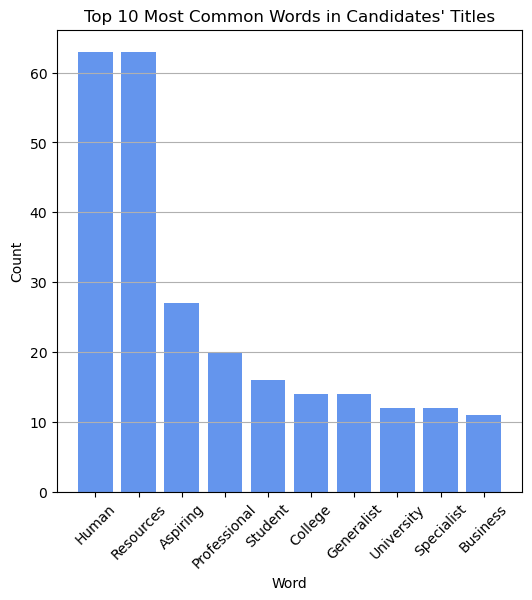

In [628]:
# make title case
word_t=[word.title() for word in word_]

plt.figure(figsize=(6,6))
plt.tight_layout()
plt.bar(x=word_t,height=count_,color='cornflowerblue')
plt.title("Top 10 Most Common Words in Candidates' Titles")
plt.xticks(rotation=45)
plt.grid(visible=True,which='major',axis='y')
plt.ylabel('Count')
plt.xlabel('Word')

plt.savefig('figures/3_top10words.pdf',bbox_inches='tight')
plt.savefig('figures/3_top10words.jpg',bbox_inches='tight')
plt.savefig('figures/3_top10words.png',bbox_inches='tight')

plt.show()

In [629]:
explanation_1 = 'We can see that'
explanation_2 = 'of candidates have the words "Human" and "Resources" in their job titles.'
print(explanation_1,f'{count_[0]/df.shape[0]*100:.2f}%',explanation_2)

We can see that 60.58% of candidates have the words "Human" and "Resources" in their job titles.


### Word Cloud of the Job Titles

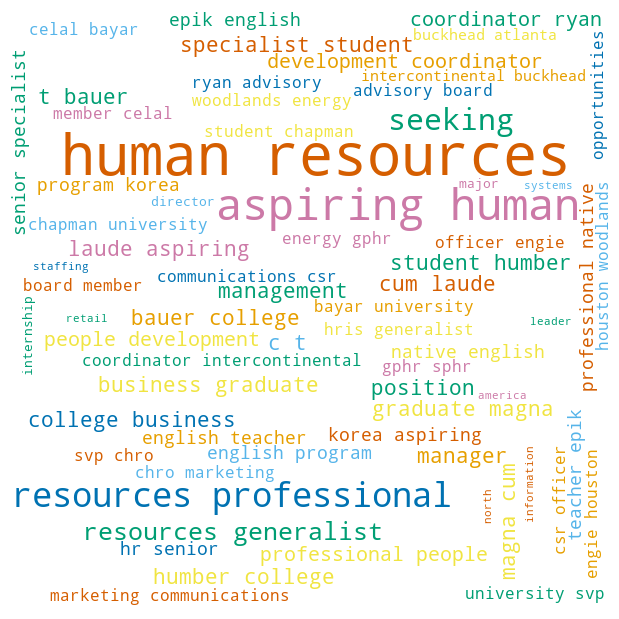

In [630]:
# taken from GeeksForGeeks.org:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

# Define list of job titles
jobs = df['job_title'].tolist()

comment_words = ''
stopwords_ = set(STOPWORDS)  # Set of stopwords for WordCloud
 
# Iterate through each job title
for job in jobs:
    # Typecast each job title to string and split into tokens by spaces
    job = str(job)
    tokens = job.split()  # Split each title into individual words
    
    # Convert each token into lowercase and add to comment_words if not a stopword
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords_]
    
    # Join tokens to build the complete comment_words string with individual words
    comment_words += " ".join(tokens) + " "
    
# Define the colorblind-friendly palette
colorblind_palette = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']

# Custom color function to apply colorblind-friendly colors
def colorblind_friendly_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colorblind_palette)
    
# Create the word cloud
cloud = WordCloud(width=600, 
                  height=600,
                  background_color='white',
                  stopwords=stopwords_,  # Pass the set of stopwords
                  min_font_size=10,
                  color_func=colorblind_friendly_color_func).generate(comment_words)
 
# Plot the WordCloud image                       
plt.figure(figsize=(6, 6), facecolor=None)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Save the word cloud as different file formats
plt.savefig('figures/3_wordcloud.pdf')
plt.savefig('figures/3_wordcloud.jpg')
plt.savefig('figures/3_wordcloud.png')

plt.show()

This is more for show, but we can see that "human","resources", and "aspiring" all appear frequently in the dataset.

# Calculate Cosine Similarity with the Search Terms

As a reminder, we are currently helping the company understand which candidates are a best fit for their human resources position. As such, the company is focusing on two search terms:
* **"Aspiring human resources"**, or
* **"Seeking human resources"**

We will pretend that the company is initializing their search terms by creating a parquet file using the following code. I'm using a Mac, so this is in Terminal:

```bash
python -c "import pandas as pd; df = pd.DataFrame({'term': ['Aspiring human resources', 'Seeking human resources']}); df.to_parquet('search_terms.parquet', engine='pyarrow')"
```

To edit the parquet file, I am using the following code. You can update the "ADD NEW SEARCH TERM HERE" as needed:
```bash
python -c "import pandas as pd; df = pd.read_parquet('search_terms.parquet', engine='pyarrow'); new_row = pd.DataFrame({'term': ['ADD NEW SEARCH TERM HERE']}); df = pd.concat([df, new_row], ignore_index=True); df.to_parquet('search_terms.parquet', engine='pyarrow')"

```

As the company updates their search term parquet file, we will upload a fresh file by running the code below.

In [674]:
search_dict=pd.read_parquet('search_terms.parquet')

search_term_df=pd.DataFrame.from_dict(search_dict)

# view the search term file
search_term_df

,term
0,Aspiring human resources
1,Seeking human resources


We will use the same preprocessor as above, without lemmatization, and will use the **cosine similarity** to determine the similarity between the job titles and the search terms.

In [675]:
df.head(3)

,id,job_title,location,connection,lat,lon,name,avg_sim_score,job_title_vector,sim_aspiring,sim_seeking,max_similarity,mean_similarity,job_title_vector_glove,sim_aspiring_glove,sim_seeking_glove,max_similarity_glove,mean_similarity_glove
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,29.7652,-95.3657,Houston,0.192527,"[-0.04938299, 0.06180087, 0.012268066, 0.11644...",0.605357,0.389790,0.605357,0.497574,"[0.045720834, 0.19056486, 0.025927793, 0.07728...",0.539872,0.478087,0.539872,0.508980
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500,45.424721,-75.695,Canada,0.000000,"[0.016438803, 0.0230306, 0.06384277, 0.0745442...",0.218221,0.104410,0.218221,0.161316,"[-0.3685978, -0.07969823, 0.059474442, -0.0723...",0.358878,0.356659,0.358878,0.357768
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,35.772701,-78.632439,Raleigh,0.539892,"[-0.09277344, 0.037231445, 0.08280945, 0.02981...",0.945019,0.700596,0.945019,0.822808,"[0.061947748, 0.288153, 0.047277495, -0.145377...",0.925663,0.799220,0.925663,0.862442


In [676]:
nltk_updater()

[nltk_data] Downloading package punkt to /Users/sra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/sra/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/sra/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/sra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [677]:
# vectorize the job_titles
# instantiate vectorizor and vectorize phrases
vec=TfidfVectorizer(preprocessor=preprocessor_nolem)
vec.fit(df['job_title']) # fit on entire job title data

# transform job titles and target phrases
df_job_titles_tfidf=vec.transform(df['job_title']) # matrix of candidate job titles
search_terms=vec.transform(search_term_df['term']) # matrix of search phrases

In [678]:
# calculate cosine similarity
sim_aspiring=cosine_similarity(df_job_titles_tfidf,search_terms[0]) # for aspiring
sim_seeking=cosine_similarity(df_job_titles_tfidf,search_terms[1])  # for seeking

In [679]:
# combine similarities into single score (maximum similarity for each candidate)
max_sim=pd.DataFrame({
    'candidate':df['id'],
    'sim_aspiring':sim_aspiring.flatten(),
    'sim_seeking':sim_seeking.flatten()
})

# max_sim['max_sim']=max_sim[['sim_aspiring','sim_seeking']].max(axis=1)
# better: highest average similarity score
max_sim['avg']=(max_sim['sim_aspiring']+max_sim['sim_seeking'])/2

# sort candidates by similarity score
# closest_candidates=max_sim.sort_values(by='max_sim',ascending=False)
closest_candidates=max_sim.sort_values(by = 'avg', ascending = False)
closest_candidates.head(10)

,candidate,sim_aspiring,sim_seeking,avg
72,73,0.576794,0.620589,0.598691
45,46,0.753591,0.326192,0.539892
57,58,0.753591,0.326192,0.539892
16,17,0.753591,0.326192,0.539892
32,33,0.753591,0.326192,0.539892
96,97,0.753591,0.326192,0.539892
2,3,0.753591,0.326192,0.539892
20,21,0.753591,0.326192,0.539892
35,36,0.695679,0.301125,0.498402
5,6,0.695679,0.301125,0.498402


In [680]:
# tuple as the order matters
top10_candidates=tuple(closest_candidates.head(10)['candidate'])
top10_candidates

(73, 46, 58, 17, 33, 97, 3, 21, 36, 6)

## Top 10 Candidates

In [681]:
# Add avg sim score to df only if it doesn't already exist
if 'avg' in max_sim.columns and 'avg_sim_score' not in df.columns:
    df = df.join(max_sim['avg']).rename(columns={'avg': 'avg_sim_score'})

# Order by similarity score based on closest_candidates
df['id'] = pd.Categorical(df['id'], categories=closest_candidates['candidate'], ordered=True)
sorted_df = df.sort_values('id')

# Display the first 10 rows
sorted_df.head(10)

,id,job_title,location,connection,lat,lon,name,avg_sim_score,job_title_vector,sim_aspiring,sim_seeking,max_similarity,mean_similarity,job_title_vector_glove,sim_aspiring_glove,sim_seeking_glove,max_similarity_glove,mean_similarity_glove
72,73,"Aspiring Human Resources Manager, seeking inte...","Houston, Texas Area",7,29.7652,-95.3657,Houston,0.598691,"[-0.07829285, 0.033935547, 0.024772644, -0.036...",0.872285,0.839220,0.872285,0.855753,"[-0.0658743, 0.0405984, -0.050965004, -0.06901...",0.883461,0.906297,0.906297,0.894879
45,46,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,35.772701,-78.632439,Raleigh,0.539892,"[-0.09277344, 0.037231445, 0.08280945, 0.02981...",0.945019,0.700596,0.945019,0.822808,"[0.061947748, 0.288153, 0.047277495, -0.145377...",0.925663,0.799220,0.925663,0.862442
57,58,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,35.772701,-78.632439,Raleigh,0.539892,"[-0.09277344, 0.037231445, 0.08280945, 0.02981...",0.945019,0.700596,0.945019,0.822808,"[0.061947748, 0.288153, 0.047277495, -0.145377...",0.925663,0.799220,0.925663,0.862442
16,17,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,35.772701,-78.632439,Raleigh,0.539892,"[-0.09277344, 0.037231445, 0.08280945, 0.02981...",0.945019,0.700596,0.945019,0.822808,"[0.061947748, 0.288153, 0.047277495, -0.145377...",0.925663,0.799220,0.925663,0.862442
32,33,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,35.772701,-78.632439,Raleigh,0.539892,"[-0.09277344, 0.037231445, 0.08280945, 0.02981...",0.945019,0.700596,0.945019,0.822808,"[0.061947748, 0.288153, 0.047277495, -0.145377...",0.925663,0.799220,0.925663,0.862442
96,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,40.49884,-86.145273,Kokomo_IN,0.539892,"[-0.09277344, 0.037231445, 0.08280945, 0.02981...",0.945019,0.700596,0.945019,0.822808,"[0.061947748, 0.288153, 0.047277495, -0.145377...",0.925663,0.799220,0.925663,0.862442
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,35.772701,-78.632439,Raleigh,0.539892,"[-0.09277344, 0.037231445, 0.08280945, 0.02981...",0.945019,0.700596,0.945019,0.822808,"[0.061947748, 0.288153, 0.047277495, -0.145377...",0.925663,0.799220,0.925663,0.862442
20,21,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,35.772701,-78.632439,Raleigh,0.539892,"[-0.09277344, 0.037231445, 0.08280945, 0.02981...",0.945019,0.700596,0.945019,0.822808,"[0.061947748, 0.288153, 0.047277495, -0.145377...",0.925663,0.799220,0.925663,0.862442
35,36,Aspiring Human Resources Specialist,Greater New York City Area,1,40.74838,-73.996705,New_York_City,0.498402,"[-0.04522705, 0.04385376, 0.09486389, 0.065460...",0.905420,0.743151,0.905420,0.824286,"[0.0919795, 0.2219905, -0.088000506, -0.030330...",0.934690,0.841785,0.934690,0.888238
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,40.74838,-73.996705,New_York_City,0.498402,"[-0.04522705, 0.04385376, 0.09486389, 0.065460...",0.905420,0.743151,0.905420,0.824286,"[0.0919795, 0.2219905, -0.088000506, -0.030330...",0.934690,0.841785,0.934690,0.888238


These are the top-10 likeliest candidate IDs for the human resource position!

# Dense Word Embeddings with `Word2Vec`

To perform a dense word embedding with Word2Vec, we will use the following process:
1. Load a pre-trained Word2Vec model
1. Average the word vectors
1. Compute average vectors for `job_title` and `search_term`
1. Calculate similarity scores

## 1. Load Word2Vec model

In [682]:
# downloaded from Kaggle:
# https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300
model = KeyedVectors.load_word2vec_format(fname='../data/GoogleNews-vectors-negative300.bin',binary=True)

## 2. Average the Word Vectors

We'll have to create a function to do so:

In [683]:
def get_set_stopwords_english():
    stop_words_english=stopwords.words('english')
    return set(stop_words_english)

def get_average_vector(text, model):
    stop_words=get_set_stopwords_english()
    # stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    
    # Filter words in vocabulary and not stopwords
    valid_words = [word for word in words if word in model and word not in stop_words]
    
    if not valid_words:  # if there are no valid words, return a zero vector
        return np.zeros(model.vector_size)
    
    # Average vectors for all valid words in the text
    word_vectors = np.array([model[word] for word in valid_words])
    average_vector = word_vectors.mean(axis=0)
    
    return average_vector

This function does the following:
1. Converts the text to lowercase
1. Tokenizes the text
1. Filters out stopwords and words not in the Word2Vec vocabulary
1. Produces a single vector for the text based on the mean of each vector

## 3. Compute Average Vectors for Job Titles and Search Terms

In [684]:
nltk_updater()

[nltk_data] Downloading package punkt to /Users/sra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/sra/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/sra/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/sra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [685]:
# compute vector for each job title
df['job_title_vector'] = df['job_title'].apply(lambda x: get_average_vector(x, model))

# get vectors for search terms
search_term_vectors=[get_average_vector(term, model) for term in search_term_df['term']]

## 4. Calculate cosine similarity between each job title vector and each of the phrase vectors.

In [686]:
# Calculate similarity scores for each candidate
df['sim_aspiring'] = df['job_title_vector'].apply(lambda x: cosine_similarity([x], [search_term_vectors[0]])[0][0])
df['sim_seeking'] = df['job_title_vector'].apply(lambda x: cosine_similarity([x], [search_term_vectors[1]])[0][0])

# Get maximum similarity score for each job title
df['max_similarity'] = df[['sim_aspiring', 'sim_seeking']].max(axis=1)
df['mean_similarity'] = df[['sim_aspiring', 'sim_seeking']].mean(axis=1)

# Sort by similarity to find closest candidates
# closest_candidates = df.sort_values(by='max_similarity', ascending=False)
closest_candidates = df.sort_values(by='mean_similarity',ascending=False)

# Display top results
# print(closest_candidates[['job_title', 'max_similarity']].head())
closest_candidates[['id','job_title','mean_similarity']].head(10)

,id,job_title,mean_similarity
72,73,"Aspiring Human Resources Manager, seeking inte...",0.855753
73,74,Human Resources Professional,0.829245
59,60,Aspiring Human Resources Specialist,0.824286
35,36,Aspiring Human Resources Specialist,0.824286
23,24,Aspiring Human Resources Specialist,0.824286
48,49,Aspiring Human Resources Specialist,0.824286
5,6,Aspiring Human Resources Specialist,0.824286
29,30,Seeking Human Resources Opportunities,0.823213
27,28,Seeking Human Resources Opportunities,0.823213
98,99,Seeking Human Resources Position,0.822808


# `GloVe` Method

The [`GloVe`](https://nlp.stanford.edu/projects/glove/) model (Global Vectors for Word Representation) is a word embedding model that provides a dense vector representation of words similar to `Word2Vec`. `GloVe` was trained on matrix factorization techniques.

We'll be using the 6B model, which can be downloaded from [here](https://nlp.stanford.edu/data/glove.6B.zip).

The steps for this method largely follows the previous method with Word2Vec:
1. Load GloVe embeddings
1. Process job titles and search terms with GloVe
1. Calculate cosine similarity

## 1. Load GloVe embeddings

In [697]:
def load_glove_model(glove_file_path):
    print("Loading GloVe model...")
    glove_model = {}
    
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_model[word] = vector
    
    print(f"GloVe model loaded with {len(glove_model)} words.")
    return glove_model

# Load the pre-trained GloVe model
glove_model = load_glove_model('../data/glove/glove.6B.300d.txt')

Loading GloVe model...
GloVe model loaded with 400000 words.


## 2. Process job titles and search terms with GloVe

Same as with Word2Vec, we will get the average glove vector value:

In [698]:
def get_average_glove_vector(text, glove_model):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    
    # Filter out stopwords and words not in the GloVe vocabulary
    valid_words = [word for word in words if word in glove_model and word not in stop_words]
    
    if not valid_words:  # Return a zero vector if no valid words are found
        return np.zeros(len(next(iter(glove_model.values()))))  # Return zero vector with the same length as GloVe vectors
    
    # Average vectors for all valid words in the text
    word_vectors = np.array([glove_model[word] for word in valid_words])
    average_vector = word_vectors.mean(axis=0)
    
    return average_vector

In [699]:
search_term_df

,term
0,Aspiring human resources
1,Seeking human resources


In [700]:
# Compute vectors for each job title
df['job_title_vector_glove'] = df['job_title'].apply(lambda x: get_average_glove_vector(x, glove_model))

# search terms from search_term_df
search_term_vectors=[get_average_glove_vector(term,glove_model) for term in search_term_df['term']]

## 3. Calculate cosine similarity

In [701]:
# Calculate similarity scores for each candidate
df['sim_aspiring_glove'] = df['job_title_vector_glove'].apply(lambda x: cosine_similarity([x], [search_term_vectors[0]])[0][0])
df['sim_seeking_glove'] = df['job_title_vector_glove'].apply(lambda x: cosine_similarity([x], [search_term_vectors[1]])[0][0])

# Get maximum similarity score for each job title
df['max_similarity_glove'] = df[['sim_aspiring_glove', 'sim_seeking_glove']].max(axis=1)
df['mean_similarity_glove'] = df[['sim_aspiring_glove', 'sim_seeking_glove']].mean(axis=1)

# Sort by similarity to find closest candidates
# closest_candidates = df.sort_values(by='max_similarity', ascending=False)
closest_candidates = df.sort_values(by='mean_similarity_glove',ascending=False)

# Display top results
# print(closest_candidates[['job_title', 'max_similarity']].head())
closest_candidates[['id','job_title','mean_similarity_glove']].head(10)

top10_candidates_glove=closest_candidates[['id','job_title','connection','mean_similarity_glove']]\
.sort_values(by='mean_similarity_glove',ascending=False)

In [702]:
# determine positions in each DataFrame
# sorted_df['position'] = sorted_df['avg_sim_score'].rank(ascending=False,method='dense').astype(int)
# top10_candidates_mean_sim['position'] = top10_candidates_mean_sim['mean_similarity'].rank(ascending=False, method = 'dense').astype(int)
top10_candidates_glove['position']=closest_candidates['mean_similarity_glove'].rank(ascending=False, method='dense').astype(int)
top10_candidates_glove

,id,job_title,connection,mean_similarity_glove,position
27,28,Seeking Human Resources Opportunities,390,0.899883,1
29,30,Seeking Human Resources Opportunities,390,0.899883,1
72,73,"Aspiring Human Resources Manager, seeking inte...",7,0.894879,2
59,60,Aspiring Human Resources Specialist,1,0.888238,3
5,6,Aspiring Human Resources Specialist,1,0.888238,3
...,...,...,...,...,...
82,83,HR Manager at Endemol Shine North America,268,0.265008,51
11,12,"SVP, CHRO, Marketing & Communications, CSR Off...",500,0.217242,52
54,55,"SVP, CHRO, Marketing & Communications, CSR Off...",500,0.217242,52
63,64,"SVP, CHRO, Marketing & Communications, CSR Off...",500,0.217242,52


In [704]:
# Merge sorted_df and top10_candidates_mean_sim on 'id' with the suffix '_cosine' for sorted_df
merged = pd.merge(
    sorted_df[['id', 'avg_sim_score', 'position']],
    top10_candidates_mean_sim[['id', 'mean_similarity', 'position']],
    on='id',
    suffixes=('_cosine', '_word2vec')
)

# Merge the result with top10_candidates_glove on 'id', adding the suffix '_glove' for the last merge
merged = pd.merge(
    merged,
    top10_candidates_glove[['id', 'mean_similarity_glove', 'position']],
    on='id'
)

# sort by position in the first dataframe for consistent ordering
merged.sort_values(by='position_cosine', inplace=True)

merged

,id,avg_sim_score,position_cosine,mean_similarity,position_word2vec,mean_similarity_glove,position
0,73,0.598691,1,0.855753,1,0.894879,2
1,46,0.539892,2,0.822808,6,0.862442,6
2,58,0.539892,2,0.822808,6,0.862442,6
3,17,0.539892,2,0.822808,6,0.862442,6
4,33,0.539892,2,0.822808,6,0.862442,6
...,...,...,...,...,...,...,...
102,18,0.000000,32,0.289752,37,0.508420,34
78,102,0.000000,32,0.283723,39,0.380408,42
79,45,0.000000,32,0.161316,50,0.357768,43
71,93,0.000000,32,0.288993,38,0.461230,36


# `fastText` method

[`fastText`](https://fasttext.cc) is another word embedding model with the advantage that it can handle out-of-vocabulary (OOV) words using subword embeddings. Said another way, it can generate embeddings for words that are not in the training vocabulary, which can be helpful for uncommon words or typos.

## 1. Load fastText embeddings

We'll be using the [Wiki News 300d](https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip) vector with subwords, measuring at 16 billion tokens. This was trained on Wikipedia in 2017.

In [716]:
# from their website

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

This takes a long time to load:

In [717]:
fasttext_model=load_vectors(fname='../data/wiki-news-300d-1M-subword.vec')

## 2. Process job titles and search terms with fastText

Same as before, we will get the average glove vector value:

In [721]:
def get_average_fasttext_vector(text, fasttext_model):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    
    # Filter out stopwords and words not in the GloVe vocabulary
    valid_words = [word for word in words if word in fasttext_model and word not in stop_words]
    
    if not valid_words:  # Return a zero vector if no valid words are found
        return np.zeros(len(next(iter(fasttext_model.values()))))  # Use the dimension from fasttext_model
    
    # Average vectors for all valid words in the text
    word_vectors = np.array([fasttext_model[word] for word in valid_words])
    average_vector = word_vectors.mean(axis=0)
    
    return average_vector

In [722]:
search_term_df

,term
0,Aspiring human resources
1,Seeking human resources


In [723]:
# Compute vectors for each job title
df['job_title_vector_fasttext'] = df['job_title'].apply(lambda x: get_average_fasttext_vector(x, fasttext_model))

# search terms from search_term_df
search_term_vectors=[get_average_fasttext_vector(term,fasttext_model) for term in search_term_df['term']]

## 3. Calculate cosine similarity

In [724]:
# Calculate similarity scores for each candidate
df['sim_aspiring_fasttext'] = df['job_title_vector_fasttext'].apply(lambda x: cosine_similarity([x], [search_term_vectors[0]])[0][0])
df['sim_seeking_fasttext'] = df['job_title_vector_fasttext'].apply(lambda x: cosine_similarity([x], [search_term_vectors[1]])[0][0])

# Get maximum similarity score for each job title
df['max_similarity_fasttext'] = df[['sim_aspiring_fasttext', 'sim_seeking_fasttext']].max(axis=1)
df['mean_similarity_fasttext'] = df[['sim_aspiring_fasttext', 'sim_seeking_fasttext']].mean(axis=1)

# Sort by similarity to find closest candidates
# closest_candidates = df.sort_values(by='max_similarity', ascending=False)
closest_candidates = df.sort_values(by='mean_similarity_fasttext',ascending=False)

# Display top results
# print(closest_candidates[['job_title', 'max_similarity']].head())
closest_candidates[['id','job_title','mean_similarity_fasttext']].head(10)

top10_candidates_fasttext=closest_candidates[['id','job_title','connection','mean_similarity_fasttext']]\
.sort_values(by='mean_similarity_fasttext',ascending=False)

In [725]:
# determine positions in each DataFrame
# sorted_df['position'] = sorted_df['avg_sim_score'].rank(ascending=False,method='dense').astype(int)
# top10_candidates_mean_sim['position'] = top10_candidates_mean_sim['mean_similarity'].rank(ascending=False, method = 'dense').astype(int)
# top10_candidates_glove['position']=closest_candidates['mean_similarity_glove'].rank(ascending=False, method='dense').astype(int)
top10_candidates_fasttext['position']=closest_candidates['mean_similarity_fasttext'].rank(ascending=False, method='dense').astype(int)
top10_candidates_fasttext

,id,job_title,connection,mean_similarity_fasttext,position
27,28,Seeking Human Resources Opportunities,390,0.953657,1
29,30,Seeking Human Resources Opportunities,390,0.953657,1
2,3,Aspiring Human Resources Professional,44,0.952916,2
20,21,Aspiring Human Resources Professional,44,0.952916,2
57,58,Aspiring Human Resources Professional,44,0.952916,2
...,...,...,...,...,...
74,75,"Nortia Staffing is seeking Human Resources, Pa...",500,0.014671,51
41,42,"SVP, CHRO, Marketing & Communications, CSR Off...",500,-0.063739,52
63,64,"SVP, CHRO, Marketing & Communications, CSR Off...",500,-0.063739,52
11,12,"SVP, CHRO, Marketing & Communications, CSR Off...",500,-0.063739,52


In [726]:
# Merge sorted_df and top10_candidates_mean_sim on 'id' with the suffix '_cosine' for sorted_df
merged = pd.merge(
    sorted_df[['id', 'avg_sim_score', 'position']],
    top10_candidates_mean_sim[['id', 'mean_similarity', 'position']],
    on='id',
    suffixes=('_cosine', '_word2vec')
)

# Merge the result with top10_candidates_glove on 'id', adding the suffix '_glove'
merged = pd.merge(
    merged,
    top10_candidates_glove[['id', 'mean_similarity_glove', 'position']],
    on='id',
    how='left',
    suffixes=('','_glove')
)

# Merge the result with top10_candidates_fasttext on 'id', adding the suffix '_fasttext'
merged = pd.merge(
    merged,
    top10_candidates_fasttext[['id', 'mean_similarity_fasttext', 'position']],
    on='id',
    how='left',
    suffixes=('','_fasttext')
)

# sort by position in the first dataframe for consistent ordering
merged.sort_values(by='position_cosine', inplace=True)

merged

,id,avg_sim_score,position_cosine,mean_similarity,position_word2vec,mean_similarity_glove,position,mean_similarity_fasttext,position_fasttext
0,73,0.598691,1,0.855753,1,0.894879,2,0.400844,37
1,46,0.539892,2,0.822808,6,0.862442,6,0.952916,2
2,58,0.539892,2,0.822808,6,0.862442,6,0.952916,2
3,17,0.539892,2,0.822808,6,0.862442,6,0.952916,2
4,33,0.539892,2,0.822808,6,0.862442,6,0.952916,2
...,...,...,...,...,...,...,...,...,...
102,18,0.000000,32,0.289752,37,0.508420,34,0.601811,26
78,102,0.000000,32,0.283723,39,0.380408,42,0.696263,19
79,45,0.000000,32,0.161316,50,0.357768,43,0.138558,48
71,93,0.000000,32,0.288993,38,0.461230,36,0.677983,20


# Compare cosine similarity scores across all methods

Compare the min and max across all methods:

In [730]:
# cosine similarity with tfidf vectorizor
print(sorted_df['avg_sim_score'].min())
print(sorted_df['avg_sim_score'].max())

0.0
0.5986913599339235


In [731]:
# word2vec
print(top10_candidates_mean_sim['mean_similarity'].min())
print(top10_candidates_mean_sim['mean_similarity'].max())

0.15162540972232819
0.8557528257369995


In [732]:
# glove
print(top10_candidates_glove['mean_similarity_glove'].min())
print(top10_candidates_glove['mean_similarity_glove'].max())

0.21724219620227814
0.8998832106590271


In [733]:
# fasttext
print(top10_candidates_fasttext['mean_similarity_fasttext'].min())
print(top10_candidates_fasttext['mean_similarity_fasttext'].max())

-0.0637385592599378
0.9536569431850905


In [ ]:
# Identify the top 10 IDs for each dataframe
top_10_cosine_ids = merged.nsmallest(10, 'position_cosine')['id']
top_10_word2vec_ids = merged.nsmallest(10, 'position_word2vec')['id']
top_10_glove_ids = merged.nsmallest(10, 'position_glove')['id']
top_10_fasttext_ids = merged.nsmallest(10, 'position_fasttext')['id']

# Combine the two sets of IDs to include all unique IDs
top_ids = pd.concat([top_10_cosine_ids,
                     top_10_word2vec_ids,
                     top_10_glove_ids,
                     top_10_fasttext_ids]).unique()

# Filter the merged dataframe to include only these top IDs
filtered_merged = merged[merged['id'].isin(top_ids)]

In [ ]:
filtered_merged

In [694]:
merged

,id,avg_sim_score,position_cosine,mean_similarity,position_word2vec
0,73,0.598691,1,0.855753,1
1,46,0.539892,2,0.822808,6
2,58,0.539892,2,0.822808,6
3,17,0.539892,2,0.822808,6
4,33,0.539892,2,0.822808,6
...,...,...,...,...,...
102,18,0.000000,32,0.289752,37
78,102,0.000000,32,0.283723,39
79,45,0.000000,32,0.161316,50
71,93,0.000000,32,0.288993,38


In [695]:
filtered_merged

,id,avg_sim_score,position_cosine,mean_similarity,position_word2vec
0,73,0.598691,1,0.855753,1
1,46,0.539892,2,0.822808,6
2,58,0.539892,2,0.822808,6
3,17,0.539892,2,0.822808,6
4,33,0.539892,2,0.822808,6
5,97,0.539892,2,0.822808,6
6,3,0.539892,2,0.822808,6
7,21,0.539892,2,0.822808,6
8,36,0.498402,3,0.824286,3
9,6,0.498402,3,0.824286,3


## Comparison Figure

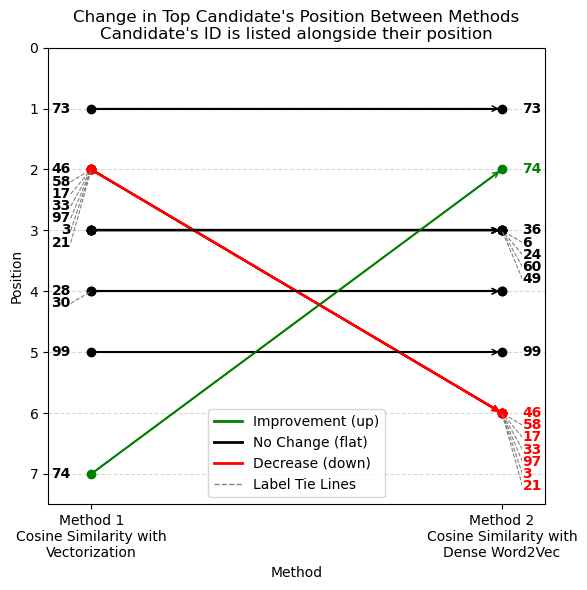

In [696]:
# Helper function to offset labels
def adjust_label_position(existing_positions, new_pos, offset=.2):
    while new_pos in existing_positions:
        new_pos += offset  # Adjust position to avoid overlap
    existing_positions.add(new_pos)
    return new_pos

# list of IDs to hide on left or right side because they're jumbled
hide_left_labels=[36,6,24,60,49]
hide_right_labels=[28,30]

plt.figure(figsize=(6, 6))

existing_positions_cosine = set()  # Track used positions for left labels
existing_positions_word2vec = set()  # Track used positions for right labels

for _, row in filtered_merged.iterrows():
    
    # determine color for arrows and labels
    if row['position_word2vec'] < row['position_cosine']:
        arrow_color = 'green'  # Improvement (up)
        font_color = 'green'
    elif row['position_word2vec'] > row['position_cosine']:
        arrow_color = 'red'  # Decrease (down)
        font_color = 'red'
    else:
        arrow_color = 'black'  # No change (straight)
        font_color = 'black'
        
    # Draw lines between positions
    plt.plot(
        [1, 2],  # Time points
        [row['position_cosine'], row['position_word2vec']],  # Ranks
        marker='o',
        color=arrow_color,
        #color='black' if row['position_cosine'] == row['position_word2vec'] else ('green' if row['position_word2vec'] < row['position_cosine'] else 'red'),
        linestyle='-'
    )
    # Add arrows
    plt.annotate(
        '', 
        xy=(2, row['position_word2vec']), 
        xytext=(1, row['position_cosine']),
        arrowprops=dict(color=('green' if row['position_word2vec'] < row['position_cosine'] 
                        else 'red' if row['position_word2vec'] > row['position_cosine'] 
                        else 'black'), arrowstyle="->")
    )
    # Determine label font weight (bold for top 10)
    # they're all bold
    left_fontweight = 'bold'
    right_fontweight = 'bold'
    # left_fontweight = 'bold' if row['position_cosine'] <= 10 else 'normal'
    # right_fontweight = 'bold' if row['position_word2vec'] <= 10 else 'normal'

    # Adjust labels to avoid overlapping
    # Left label (cosine position)
    fontsize=10
    if row['id'] not in hide_left_labels:  # Check if ID is in hide list for left
        adjusted_position_cosine = adjust_label_position(existing_positions_cosine, row['position_cosine'])
        plt.text(0.95, adjusted_position_cosine, f"{int(row['id'])}", ha='right', va='center', fontsize=fontsize, fontweight=left_fontweight)
        # Tie line for left label
        if adjusted_position_cosine != row['position_cosine']:
            plt.plot([0.95, 1], [adjusted_position_cosine, row['position_cosine']], color='gray', linestyle='--', linewidth=0.8)

    # Right label (word2vec position)
    if row['id'] not in hide_right_labels:  # Check if ID is in hide list for right
        adjusted_position_word2vec = adjust_label_position(existing_positions_word2vec, row['position_word2vec'])
        plt.text(2.05, adjusted_position_word2vec, f"{int(row['id'])}", ha='left', va='center', fontsize=fontsize, 
                 fontweight=right_fontweight, color=font_color,
                 clip_on=True, bbox=dict(facecolor='white', edgecolor='none', pad=0.2))
        # Tie line for right label
        if adjusted_position_word2vec != row['position_word2vec']:
            plt.plot([2.05, 2], [adjusted_position_word2vec, row['position_word2vec']], color='gray', linestyle='--', linewidth=0.8)

# Define custom legend elements with simple lines instead of arrows
legend_elements = [
    Line2D([0], [1], color='green', lw=2, label='Improvement (up)'),  # Line up
    Line2D([0], [1], color='black', lw=2, label='No Change (flat)'),   # Straight line
    Line2D([0], [1], color='red', lw=2, label='Decrease (down)'),     # Line down
    Line2D([0], [1], color='gray', linestyle='--', lw=1, label='Label Tie Lines')  # Tie lines
]

# Add legend to plot with a title
plt.legend(handles=legend_elements, loc='lower center', ncol=1, frameon=True)#, title='Position Changes')
            
# Customize plot
plt.xticks([1, 2], ['Method 1\nCosine Similarity with\nVectorization', 'Method 2\nCosine Similarity with\nDense Word2Vec'])
plt.gca().invert_yaxis()  # Rank 1 on top
plt.xlabel('Method')
plt.ylabel('Position')
plt.title("Change in Top Candidate's Position Between Methods\nCandidate's ID is listed alongside their position")

# Set gridlines
y_min = 0
y_max = 25
plt.yticks(np.arange(y_min, y_max + 1, 1))
plt.gca().yaxis.grid(True)
plt.ylim(7.5, 0)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig('figures/3_positionchange.pdf')
plt.savefig('figures/3_positionchange.jpg')
plt.savefig('figures/3_positionchange.png')

plt.show()